# Project Topic

This project uses deep learning models, specifically BiLTSM and BiGRU to classify medical texts into three categories: thyroid, lung, and colon cancer. The dataset consists of medical abstracts and research papers, each six pages or fewer in length.

# Load Libraries

In [1]:
#!pip install keras-tuner

In [189]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import os
import glob
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import tensorflow as tf
import numpy as np
import html
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
import pickle
from tensorflow import keras
import keras_tuner as kt
from scipy.stats import skew
from gensim.models import KeyedVectors
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import tensorflow.keras.backend as K

Configure notebook for reproducibility

In [164]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Inspect File

Load the file from the data folder inside the current directory.

In [4]:
current_dir = os.getcwd()
folder_name = "data/"
file_name = "alldata_1_for_kaggle.csv"

full_path = os.path.join(current_dir, folder_name, file_name)
df_all_data = pd.read_csv(full_path, encoding='ISO-8859-1')
display(df_all_data)

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...
...,...,...,...
7565,7565,Colon_Cancer,we report the case of a 24yearold man who pres...
7566,7566,Colon_Cancer,among synchronous colorectal cancers scrcs rep...
7567,7567,Colon_Cancer,the heterogeneity of cancer cells is generally...
7568,7568,Colon_Cancer,"""adipogenesis is the process through which mes..."


In [5]:
df_all_data.shape

(7570, 3)

In [6]:
df_all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7570 non-null   int64 
 1   0           7570 non-null   object
 2   a           7570 non-null   object
dtypes: int64(1), object(2)
memory usage: 177.6+ KB


In [7]:
df_all_data.groupby('0').count()

,Unnamed: 0,a
0,,
Colon_Cancer,2580,2580
Lung_Cancer,2180,2180
Thyroid_Cancer,2810,2810


# Data Description

This data set was retrieved from Kaggle and represents 7,570 article abstracts or research papers of less than 6 pages. Each article pertains to one of three cancer types: colon, thyroid or lung. 

There are 3 columns within the dataset:
 - `Unnamed: 0` is the row number.
 - `0` is the label which is either Colon_Cancer, Thyroid_Cancer or Lung_Cancer.
 - `a` is the article text.



# Data Cleaning

During the data cleaning process, we will:
- check for missing data
- check for duplicates
- rename the columns to for clarity

### Check for blank strings

In [8]:
blank_count = df_all_data['a'].astype(str).str.strip().eq('').sum()
print(blank_count)

0


### Check for duplicates

In [9]:
duplicate_count = df_all_data.duplicated(subset=['a']).sum()
print(f"Number of duplicates: {duplicate_count}")

Number of duplicates: 6574


In [10]:
df_deduped = df_all_data.drop_duplicates(subset= ['a'], keep='first')
record_count = len(df_deduped)
print(f"Number of records: {record_count}")

Number of records: 996


### Adjust the column names

In [11]:
df_deduped = df_deduped.drop('Unnamed: 0', axis=1)
df_deduped = df_deduped.rename(columns = {'0' : 'label', 'a' : 'text'})
df_deduped.head()

,label,text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


## Data Cleaning Summary

There was not any missing data. However, there were 6,574 duplicate articles, which were removed leaving the data set with 996 articles. The column names were adjusted to better reflect the data by changing `0` to `label` and `a` to `text`, the `Unnamed: 0` column was also dropped as it represented the row number and was inconsequential for the task at hand.

# EDA

During EDA, we will be looking at:
- category breakdown to determine if there is class imbalance
- word statistics to understand distribution of words and any potential differences in terms or article length

## Category Breakdown

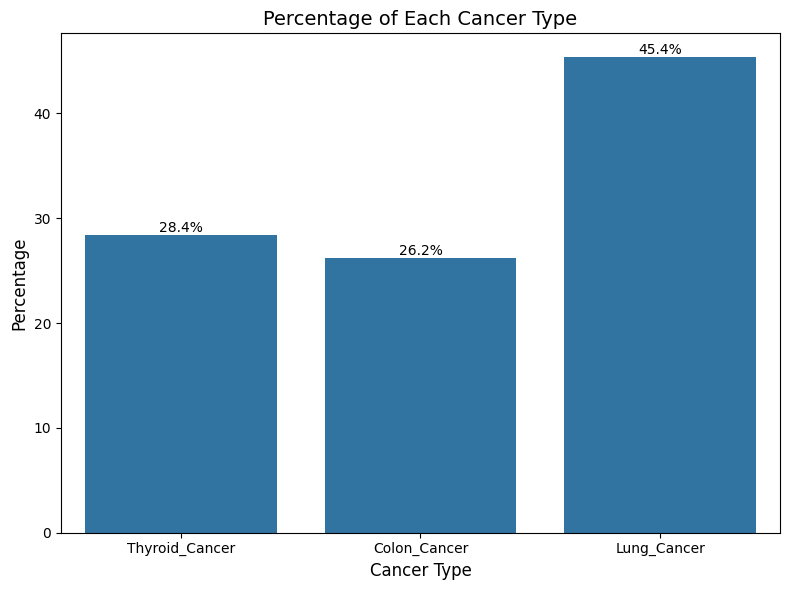

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(df_deduped, x="label", stat="percent")

ax.set_title("Percentage of Each Cancer Type", fontsize = 14)
ax.set_xlabel("Cancer Type", fontsize = 12)
ax.set_ylabel("Percentage", fontsize = 12)

ax.bar_label(ax.containers[0], fmt='%.1f%%')

plt.tight_layout()
plt.show()


After removing the duplicates there is some class imbalance.

## Word Statistics

### Descriptive Statistics

We will start by looking at the descriptive statistics around the article texts for each category. 

In [13]:
def text_stats(texts):
    all_words = ' '.join(texts).lower().split()
    word_counts = texts.apply(lambda x: len(x.split()))
    mean_word_count = word_counts.mean()
    median_word_count = word_counts.median()
    unique_word_count = len(set(all_words))
    unique_word_percentage = round(unique_word_count / len(all_words) * 100, 2)
    most_common_word = Counter(all_words).most_common(1)[0][0] if all_words else None

    stopword_count = sum(1 for word in all_words if word in ENGLISH_STOP_WORDS)
    stopword_percentage = round(stopword_count / len(all_words) * 100, 2) if all_words else 0


    return pd.Series({
        'Avg Word Count': mean_word_count,
        'Median Word Count': median_word_count,
        'Most Common Word': most_common_word,
        'Unique Word Percent': unique_word_percentage,
        'Stopword Percent': stopword_percentage

    })


In [14]:
target_stats = df_deduped.groupby('label')['text'].apply(text_stats).reset_index()
df_target_stats_long = pd.DataFrame(target_stats)
df_target_stats_wide = df_target_stats_long.pivot(index='label', columns='level_1', values='text')
df_target_stats_wide.columns.name = None
df_target_stats_wide.sort_values(by='Avg Word Count', ascending=False, inplace = True)

In [15]:
df_target_stats_wide

,Avg Word Count,Median Word Count,Most Common Word,Stopword Percent,Unique Word Percent
label,,,,,
Colon_Cancer,4147.180077,4396.0,the,33.05,10.29
Thyroid_Cancer,4070.321555,4323.0,the,32.99,10.46
Lung_Cancer,1940.5,1591.0,the,32.03,5.52


There are more words in the colon and thyroid articles than the lung cancer. This indicates that longer articles tend to pertain to colon cancer or thyroid cancer and shorter articles pertain to lung cancer. The usage of stopwords is relatively equal across all groups.

### Distribution Length By Category Label

In [16]:
df_deduped['text_length'] = df_deduped['text'].str.len()

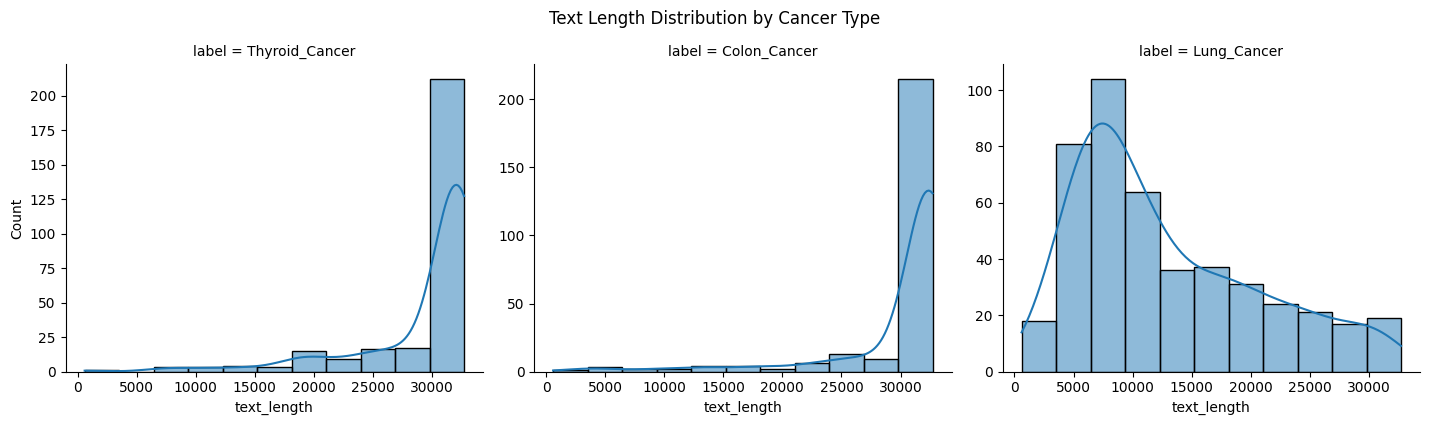

In [17]:
sns.displot(
    data=df_deduped,
    x='text_length',
    col='label',
    kind='hist',
    kde=True,
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True},
    height=4,
    aspect=1.2
)

plt.suptitle("Text Length Distribution by Cancer Type", y=1.05)
plt.show()

The text distribution plots further confirm that the lung cancer articles tend to be generally shorter in length, but also more varied than the thyroid and colon cancer articles.

Confirm skewness 

In [18]:
colon_skew = skew(df_deduped[df_deduped['label'] == 'Colon_Cancer']['text_length'])
thyroid_skew = skew(df_deduped[df_deduped['label'] == 'Thyroid_Cancer']['text_length'])
lung_skew = skew(df_deduped[df_deduped['label'] == 'Lung_Cancer']['text_length'])

print(f"Colon Cancer Skew: {colon_skew:.2f}")
print(f"Thyroid Cancer Skew: {thyroid_skew:.2f}")
print(f"Lung Cancer Skew: {lung_skew:.2f}")

Colon Cancer Skew: -3.10
Thyroid Cancer Skew: -2.46
Lung Cancer Skew: 0.83


### Top 10 Words by Category

Let's take a look at the top 10 words by category to see if there are any obvious similarities or differences. For this task, we will remove the English stopwords to keep from muddying the picture.

In [19]:
def top_10_words_by_label(df):
    labels = df['label'].unique()
    fig, ax = plt.subplots(1, len(labels), figsize=(6 * len(labels), 8))  

    if len(labels) == 1:
        ax = [ax]  

    for idx, label_val in enumerate(labels):
        subset = df[df['label'] == label_val]

        # Remove missing or empty text
        subset = subset[subset['text'].notnull() & subset['text'].str.strip().ne('')]
        text_list = subset['text'].astype(str).tolist()

       
        # CountVectorizer with stopwords
        vectorizer = CountVectorizer(lowercase=True, stop_words='english')
        X = vectorizer.fit_transform(text_list)

        
        word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
        top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]

        
        words, freqs = zip(*top_words)

        # Plotting
        ax[idx].bar(words, freqs, color='skyblue')
        ax[idx].set_title(f"Top 10 Words ({label_val})", fontsize=14)
        ax[idx].set_xlabel("Words")
        ax[idx].set_ylabel("Frequency")
        ax[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


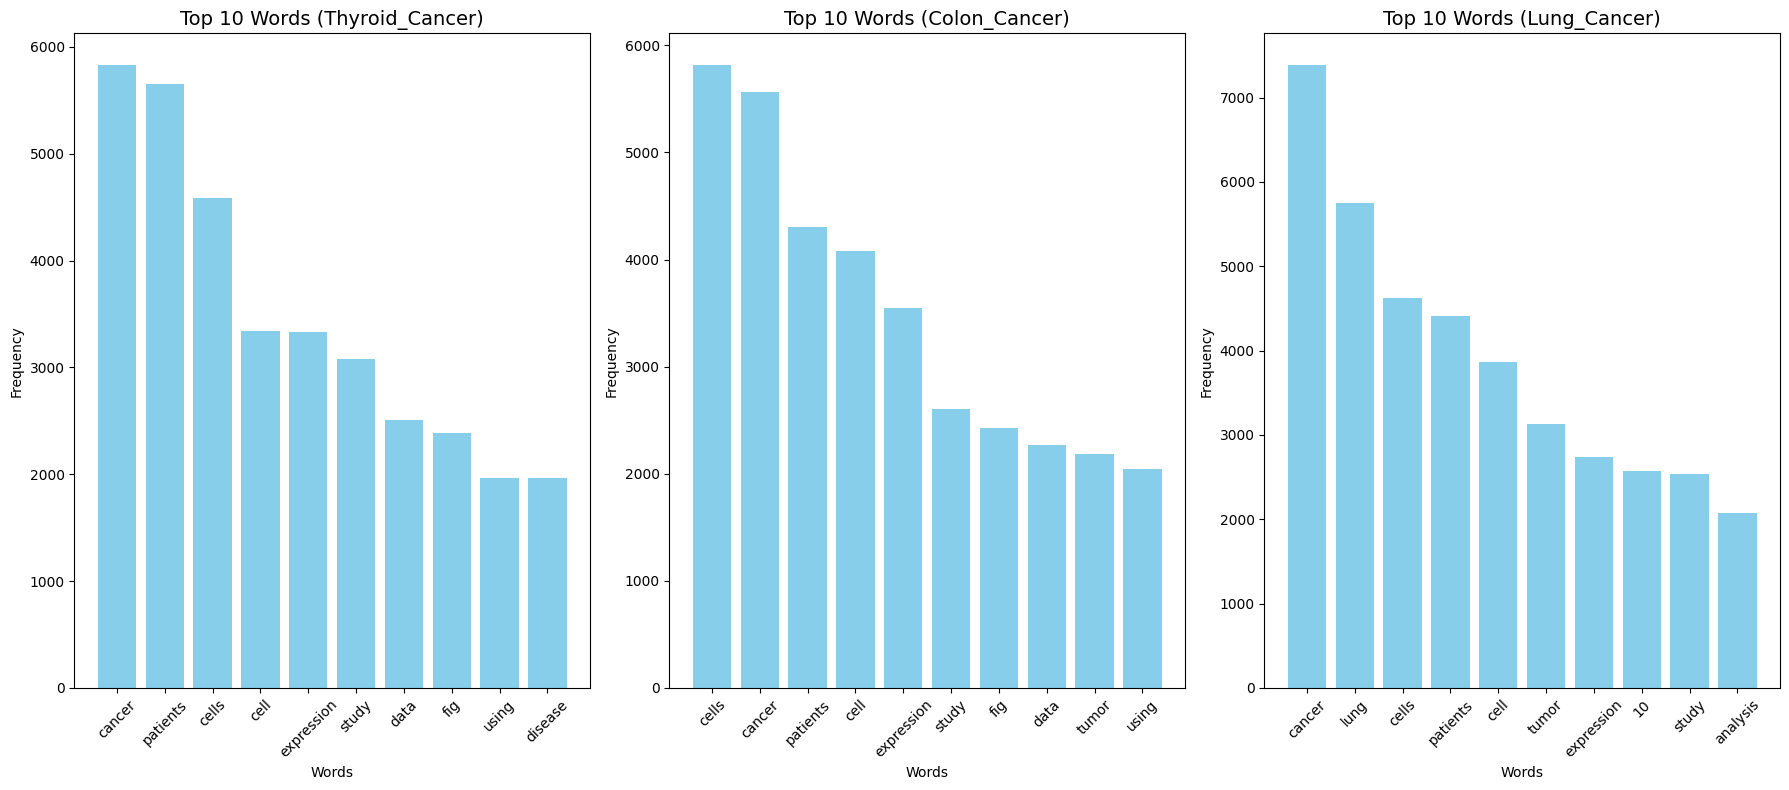

In [20]:
top_10_words_by_label(df_deduped)

We're seeing a lot of similarities across the categories, with words like cell/cells, cancer, expression and patients appearing in all categories.

## EDA Summary

The EDA process confirmed:
- The categories are imbalanced.
- The categories are string labels, not numeric values.
- The average word count is much lower for lung cancer than colon and thyroid, which have similar averages. 
- All three categories have  a high percentage of stopwords.
- Unique word percentage is also lower for lung cancer than the other two categories.
- Colon cancer and thyroid cancer are both left-skewed distributions while lung cancer is a less extreme right-skewed distribution. This leads to the conclusion that the texts labeled colon cancer and thyroid cancer are more likely to be the longer form research papers while the texts labeled lung cancer are more likely to be the shorter form abstracts.
- Top 10 words are nearly indentical across labels, supporting the need for a custom stopword list. 

## Implications for Preprocessing:
Based on these finding, the following preprocessing steps will be taken:
- Splitting the data into training and testing
- Encode the labels
- Removing stopwords, including a custom domain-specific stopword list, as a part of the text cleaning, prior to lemmatization 
- Creating word embeddings
- Addressing class imbalance


# Preprocessing

## Splitting the Data

We will begin by splitting the data into a training and testing set (80/20) and stratify the labels to ensure equal proportions of each category across the training and testings sets.

In [21]:
texts = df_deduped['text']   
labels = df_deduped['label']  

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, stratify=labels, test_size=0.2, random_state=SEED
)

In [23]:
print(y_train[:5])

856       Lung_Cancer
349      Colon_Cancer
35     Thyroid_Cancer
549       Lung_Cancer
683       Lung_Cancer
Name: label, dtype: object


## Encode the Labels

We can see after splitting the data that are labels are still represented as strings and will need to be encoded before using in the model. 

In [24]:
le = LabelEncoder()
le.classes_ = np.array(['colon_cancer', 'lung_cancer', 'thyroid_cancer'])  

y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [25]:
print(le.classes_)
print(np.unique(y_train_enc, return_counts=True))
print(np.unique(y_val_enc, return_counts=True))

['Colon_Cancer' 'Lung_Cancer' 'Thyroid_Cancer']
(array([0, 1, 2]), array([209, 361, 226]))
(array([0, 1, 2]), array([52, 91, 57]))


In [26]:
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [27]:
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Colon_Cancer': 0, 'Lung_Cancer': 1, 'Thyroid_Cancer': 2}


## General Preprocessing, Removal of Stopwords & Lemmatization

We will build a custom stopword list that consists of the words found in all three categories' top 10 words. This will then be combined with sklearn's English stop words list to create a final list of words to be removed. 

A custom text cleaning function will be utilized to perform general preprocessing including converting all text to lowercase, removing punctuation and digits, and stripping excess whitespace. The text will then be split into individual tokens and each token that is not found in the custom stopword list will be lemmatized.

In [28]:
download('stopwords')
download('wordnet')
download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jillstinnett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jillstinnett/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jillstinnett/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
custom_stopwords = set([
    'cancer', 'cells', 'cell', 'patients', 'study', 'data', 
    'expression', 'tumor', 'fig', 'using', 'analysis'
])

combined_stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

In [30]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    # Remove non-ASCII characters (weird symbols, encoding issues)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Remove punctuation (keep letters and numbers, drop - _ , . etc.)
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and lemmatize, filtering stopwords
    tokens = text.split()
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in combined_stopwords
    ]

    return ' '.join(cleaned_tokens)




In [31]:
X_train_cleaned = X_train.apply(clean_text)
X_val_cleaned = X_val.apply(clean_text)

## Tokenizer


Before feeding our text into the model, we need to convert it to a numerical format. As a part of this process, we first will examine the summary statistics of word counts across the training abstracts. This will help us determine a maximum sequence length for padding. As shown below, most abstracts fall between roughly 1,000 and 2,800 words. Based on this, we are selecting a maximum length of 2,800 which closely aligns with the 75th percentile.

Next, we will use the Keras tokenizer to convert each word into a corresponding integer based on frequency. We will then apply post padding to ensure all sequences are the same length. 

In [32]:
abstract_lengths = X_train_cleaned.apply(lambda x: len(x.split()))
abstract_lengths.describe()

count     796.000000
mean     1968.947236
std       942.141918
min       111.000000
25%       999.000000
50%      2401.500000
75%      2786.000000
max      3451.000000
Name: text, dtype: float64

In [33]:
MAX_LEN = 2800

In [34]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cleaned)  

X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_val_seq = tokenizer.texts_to_sequences(X_val_cleaned)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')

In [35]:
X_train_pad.shape, X_val_pad.shape


((796, 2800), (200, 2800))

## Embeddings

Now that we have cleaned and tokenized our data, we need to transform the words into vectors prior to modeling. There are several options for word embedding, including GloVe or training a custom embedding layer with Keras. Our concern with a general model like GloVe was that it may not capture the specialized terminology used in medical articles. While training our own embedding layer could offer more tailored representations, we feared the potential of overfitting given the small size of the dataset. 

In the end, we selected BioWordVec, a pre-trained model trained on PubMed and MIMIC-III data. This model provides domain specific representations that align well with the medical context of our dataset. Additionally, because our dataset is relatively small, using a pre-trained embedding reduces the risk of overfitting.

In [36]:
model = KeyedVectors.load_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True)

In [37]:
embedding_dim = 200
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in model:
        embedding_matrix[i] = model[word]

In [38]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True 
    
)


2025-06-10 12:21:52.220029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-06-10 12:21:52.220092: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-06-10 12:21:52.220098: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-06-10 12:21:52.220114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-10 12:21:52.220126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Class Imbalance

As mentioned earlier, we need to deal with the issue of class imbalance. We will first determine the weights for each class. That information will then be passed to the model during training. This ensures the model does not become biased toward the majority class. Since lung cancer is the largest proportion of the data, it will receive the lowest weight.

In [39]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.2695374800637957, 1: 0.7349953831948292, 2: 1.1740412979351031}


# BiLSTM Model Building

## BiLSTM Architecture
To begin, our model architecture will consist of:
- A pre-defined BioWordVec embedding layer.
- A max length of 2,800 words.
- Balanced class weights to account for class imbalance.
- A Long Short-Term Memory (LSTM) layer with 64 units wrapped in a Bidirectional wrapper.
- A dropout rate of 30% to the output of the LSTM layer to help prevent overfitting.
- A fully connected (dense) layer with 64 units and ReLU activation.
- A final output layer with 3 units and a softmax activation since there are more than 2 categories.

During the model fitting, we will be inspecting the accuracy and loss plots for overfitting and instability and tune the model as needed.

In [40]:
tf.random.set_seed(SEED)

model_lstm = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [43]:
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/bilstm_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_bilstm = model_lstm.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_cb, checkpoint_cb] 
)

Epoch 1/10


2025-06-10 12:21:52.982159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.3516 - loss: 1.0442
Epoch 1: saving model to models/bilstm_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.3558 - loss: 1.0443 - val_accuracy: 0.5350 - val_loss: 1.0851
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6294 - loss: 0.9834
Epoch 2: saving model to models/bilstm_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.6276 - loss: 0.9845 - val_accuracy: 0.5200 - val_loss: 1.0521
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6298 - loss: 0.9436
Epoch 3: saving model to models/bilstm_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.6283 - loss: 0.9447 - val_accuracy: 0.5450 - val_loss: 1.0122
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6246 - loss: 0.9041
Epoch 4: saving model to models/bilstm_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.6219 - loss: 0.9055 - val_accuracy: 0.3250 - 

In [44]:
#with open('models/history_lstm_bidirectional.pkl', 'wb') as f:
    #pickle.dump(history_bilstm.history, f)

In [45]:
#Load History (Needed if in New Session)
#with open('models/history_lstm_bidirectional.pkl', 'rb') as f:
    #history_dict = pickle.load(f)

### Plot Loss & Accuracy of Max Length = 2800

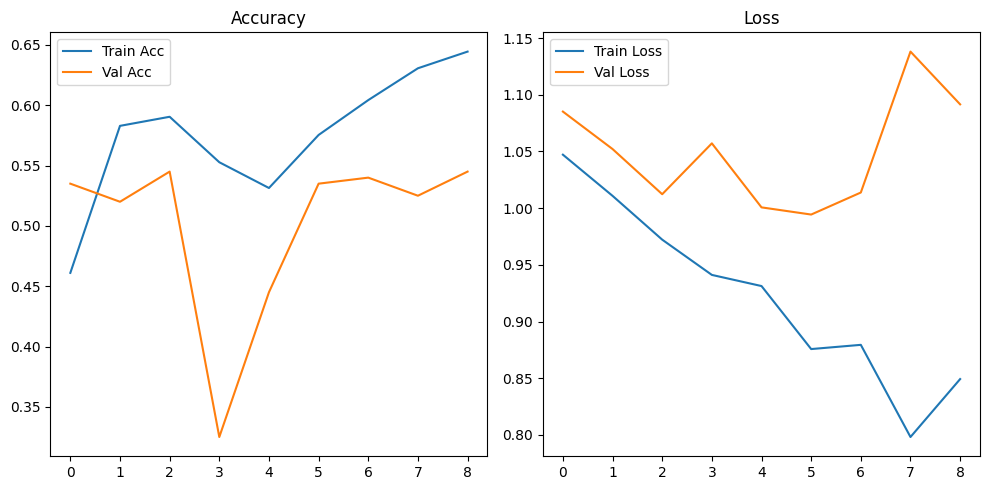

In [47]:
train_loss = history_bilstm.history['loss']
val_loss = history_bilstm.history['val_loss']
epochs_range = range(1, len(train_loss) + 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_bilstm.history['accuracy'], label='Train Acc')
axs[0].plot(history_bilstm.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_bilstm.history['loss'], label='Train Loss')
axs[1].plot(history_bilstm.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plot Summary of Max_Length=2800
The model continues to improve on the training accuracy and loss, but validation accuracy and loss are both unstable. Validation accuracy fluctuates and remains low, while validation loss spikes at several points. This instability suggests that a sequence length of 2,800 tokens may be too long for the model to generalize effectively. As a next step, we will be reducing the max length to 2,400 which is roughly the 50th percentile.

## Fine-Tuning BiLSTM

As previously mentioned, we will begin fine tuning the BiLSTM by adjusting the max length to 2,400.

### Max Length Adjusted to 2,400

In [322]:
#Adjust max length
MAX_LEN = 2400
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

In [55]:
tf.random.set_seed(SEED)

model_lstm_2400 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [58]:
model_lstm_2400.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_lstm_2400 = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/bilstm_2400_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_lstm_2400 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_bilstm_2400 = model_lstm_2400.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_lstm_2400, checkpoint_lstm_2400] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4599 - loss: 0.9965
Epoch 1: saving model to models/bilstm_2400_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.4641 - loss: 0.9958 - val_accuracy: 0.6450 - val_loss: 1.0046
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6983 - loss: 0.8780
Epoch 2: saving model to models/bilstm_2400_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.6972 - loss: 0.8773 - val_accuracy: 0.6050 - val_loss: 0.8359
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7204 - loss: 0.7616
Epoch 3: saving model to models/bilstm_2400_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.7197 - loss: 0.7619 - val_accuracy: 0.6900 - val_loss: 0.7942
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7355 - loss: 0.7137
Epoch 4: saving model to models/bilstm_2400_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.7348 - loss: 0

### Plot Accuracy & Loss Max Length = 2400

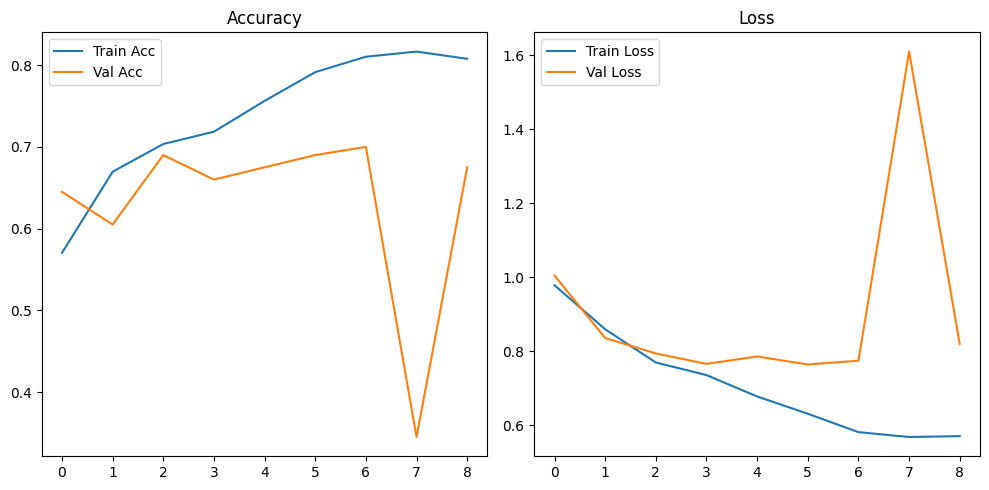

In [60]:
train_loss_2400 = history_bilstm_2400.history['loss']
val_loss_2400 = history_bilstm_2400.history['val_loss']
epochs_range_2400 = range(1, len(train_loss_2400) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_bilstm_2400.history['accuracy'], label='Train Acc')
axs[0].plot(history_bilstm_2400.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_bilstm_2400.history['loss'], label='Train Loss')
axs[1].plot(history_bilstm_2400.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plot Summary of Max_Length=2400

Epochs 0 to 6 are showing a steady smooth decline for training loss, indicating that the model is learning effectively. Likewise the validation loss is decreasing at a similar rate, suggesting the model is not overfitting during this period. On the accuracy side, both training and validation improve, but the accuracy improvement happens more rapidly for the training set than the validation set. 

After epoch 6, validation loss and accuracy become extremely unstable, with a sharp spike in loss and drop in accuracy. This suggests the model may be encountering instability, possibly due to the high max_length value of 2400. Based on this behavior, our next step is to once again reduce the maximum sequence length to help stabilize training and improve generalization.

### Max Length Adjusted to 2,000

In [166]:
#Adjust max length
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))


In [168]:
tf.random.set_seed(SEED)

model_lstm_2000 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [171]:
model_lstm_2000.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_lstm_2000 = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/bilstm_2000_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_lstm_2000 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_bilstm_2000 = model_lstm_2000.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_lstm_2000, checkpoint_lstm_2000] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4859 - loss: 1.0211
Epoch 1: saving model to models/bilstm_2000_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4895 - loss: 1.0201 - val_accuracy: 0.5850 - val_loss: 1.0413
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6635 - loss: 0.9160
Epoch 2: saving model to models/bilstm_2000_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.6632 - loss: 0.9146 - val_accuracy: 0.5900 - val_loss: 0.8547
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6923 - loss: 0.7670
Epoch 3: saving model to models/bilstm_2000_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.6918 - loss: 0.7669 - val_accuracy: 0.5950 - val_loss: 0.8385
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7288 - loss: 0.7039
Epoch 4: saving model to models/bilstm_2000_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.7286 - loss: 0

### Plot Accuracy & Loss Max Length = 2000

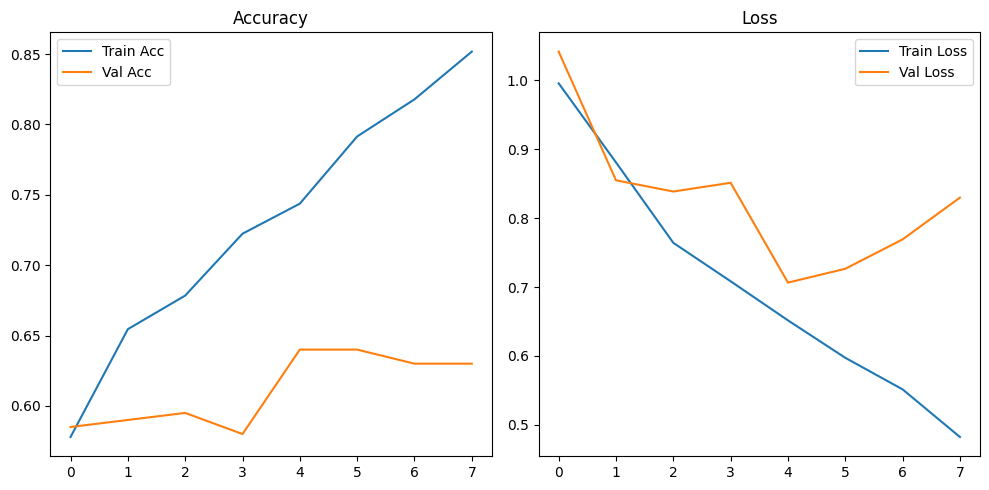

In [173]:
train_loss_2000 = history_bilstm_2000.history['loss']
val_loss_2000 = history_bilstm_2000.history['val_loss']
epochs_range_2000 = range(1, len(train_loss_2000) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_bilstm_2000.history['accuracy'], label='Train Acc')
axs[0].plot(history_bilstm_2000.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_bilstm_2000.history['loss'], label='Train Loss')
axs[1].plot(history_bilstm_2000.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plot Summary of Max_Length=2000

Training accuracy steadily increases while training loss steadily decreases when max length is set to 2,000. In addition, we begin to see a stabilizing of accuracy for the validation set. While validation loss is still not completely stable, it is more stable than the other sequence lengths tested. Since we're seeing some overfitting after epoch 4-5, which is evidenced by the validation loss starting to rise while the training loss continues to drop, we are going to increase the dropout rate. Higher dropout will encourage generalization and reduce the gap between the training and validation loss. We will begin by slightly increasing the dropout rate to 0.35.

### Dropout Rate Tuning, Dropout Rate Increase to 0.35

In [182]:
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

{0: 1.2695374800637957, 1: 0.7349953831948292, 2: 1.1740412979351031}


In [183]:
tf.random.set_seed(SEED)

model_lstm_2000b = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [186]:
model_lstm_2000b.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_lstm_2000b = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/bilstm_2000b_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_lstm_2000b = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_bilstm_2000b = model_lstm_2000b.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_lstm_2000b, checkpoint_lstm_2000b] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4673 - loss: 1.0242
Epoch 1: saving model to models/bilstm_2000b_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.4709 - loss: 1.0233 - val_accuracy: 0.5750 - val_loss: 1.0349
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6649 - loss: 0.9006
Epoch 2: saving model to models/bilstm_2000b_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.6643 - loss: 0.8995 - val_accuracy: 0.5650 - val_loss: 0.8566
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6896 - loss: 0.7695
Epoch 3: saving model to models/bilstm_2000b_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.6892 - loss: 0.7695 - val_accuracy: 0.5950 - val_loss: 0.8116
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7486 - loss: 0.7064
Epoch 4: saving model to models/bilstm_2000b_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.7478 - los

### Plot Accuracy & Loss Dropout Rate = 0.35

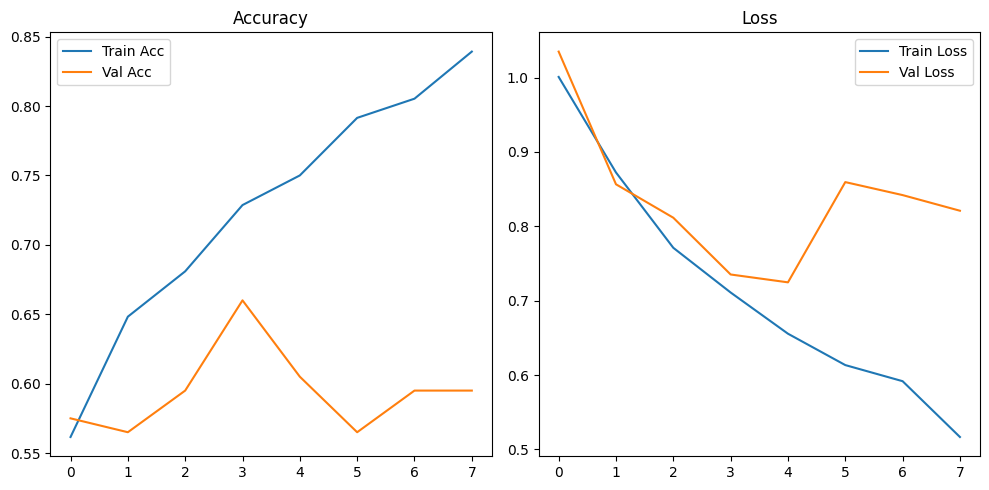

In [187]:
train_loss_2000b = history_bilstm_2000b.history['loss']
val_loss_2000b = history_bilstm_2000b.history['val_loss']
epochs_range_2000b = range(1, len(train_loss_2000b) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_bilstm_2000b.history['accuracy'], label='Train Acc')
axs[0].plot(history_bilstm_2000b.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_bilstm_2000b.history['loss'], label='Train Loss')
axs[1].plot(history_bilstm_2000b.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plot Summary of Increased Dropout Rate (0.35)

Increasing the dropout rate has improved the validation loss results without hurting training accuracy, training loss or validation accuracy. That being said, we're seeing a plateau for the validation accuracy around epochs 5 to 7. In an attempt to counteract this, we are going to update the learning rate with a learning rate scheduler. 

### Adding Learning Rate Scheduler

For this process we will be using TensorFlow's callback, ReduceLROnPlateau, which reduces the learning rate when a specified metric has stopped improving. We will set the patience parameter to 3, meaning if validation loss does not improve over 3 epochs, the learning rate will be reduced. 

In [222]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [224]:
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

In [225]:
tf.random.set_seed(SEED)

model_lstm_2000c = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [228]:
model_lstm_2000c.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_lstm_2000c = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/bilstm_2000c_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

#updated patience to provide time for adjusted learning rate 
earlystop_lstm_2000c = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=6,
    restore_best_weights=True,
    verbose = 1
)

history_bilstm_2000c = model_lstm_2000c.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_lstm_2000c, checkpoint_lstm_2000c, lr_scheduler] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5266 - loss: 1.0249
Epoch 1: saving model to models/bilstm_2000c_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.5289 - loss: 1.0239 - val_accuracy: 0.5700 - val_loss: 1.0209 - learning_rate: 0.0010
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6460 - loss: 0.8915
Epoch 2: saving model to models/bilstm_2000c_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.6461 - loss: 0.8899 - val_accuracy: 0.5750 - val_loss: 0.8628 - learning_rate: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6662 - loss: 0.7802
Epoch 3: saving model to models/bilstm_2000c_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.6662 - loss: 0.7800 - val_accuracy: 0.6050 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7287 - loss: 0.7137
Epoch 4: saving model to models/bilstm_2000c_epoch_04

### Plot Accuracy & Loss for Learning Rate

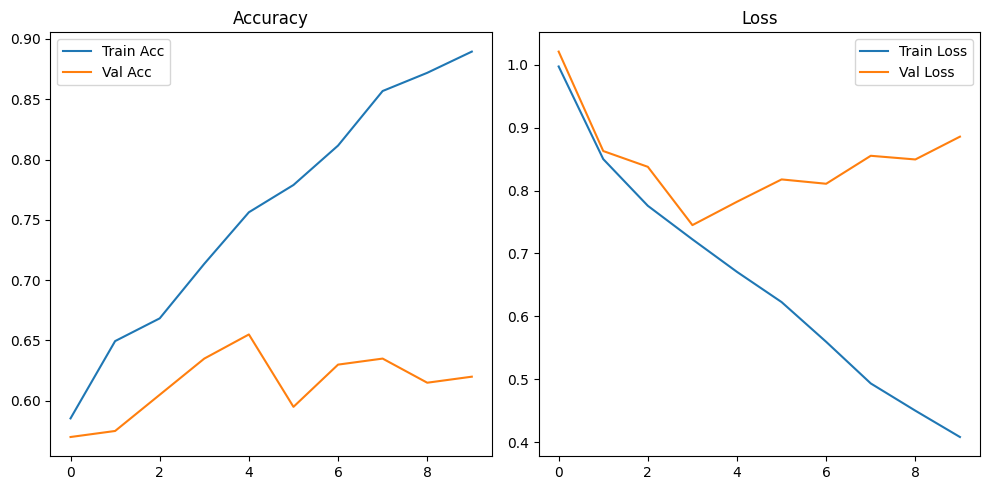

In [229]:
train_loss_2000c = history_bilstm_2000c.history['loss']
val_loss_2000c = history_bilstm_2000c.history['val_loss']
epochs_range_2000c = range(1, len(train_loss_2000c) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_bilstm_2000c.history['accuracy'], label='Train Acc')
axs[0].plot(history_bilstm_2000c.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_bilstm_2000c.history['loss'], label='Train Loss')
axs[1].plot(history_bilstm_2000c.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plots Learning Rate Scheduler 

The learning rate scheduler did not improve model performance. As shown in the plots, validation loss increased and remained unstable. Since the previous BiLSTM model plateaued for validation accuracy and had a decreasing validation loss, we will treat it as our best BiLSTM model and use it for comparison purposes going forward.

# BiGRU Model Building

We will be building a BiGRU model and comparing the results to our tuned BiLSTM model. Because we saw enhanced performance when we increased our dropout rate to 35% and decreased our max length to 2,000 words, these will be the values used in the BiGRU base model.

## BiGRU Architecture 

To begin, our model architecture will consist of:
- A pre-defined BioWordVec embedding layer.
- A max word length of 2,000 words.
- Balanced class weights to account for class imbalance.
- A Gated Recurrent Unit (GRU) layer with 64 units wrapped in a Bidirectional wrapper.
- A dropout rate of 35% to the output of the GRU layer to help prevent overfitting.
- A fully connected (dense) layer with 64 units and ReLU activation.
- A final output layer with 3 units and a softmax activation since there are more than 2 categories.


In [237]:
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))



In [238]:
tf.random.set_seed(SEED)

model_gru_2000 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [241]:
model_gru_2000.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_gru_2000 = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/gru_2000_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_gru_2000 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=6,
    restore_best_weights=True,
    verbose = 1
)

history_gru_2000 = model_gru_2000.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_gru_2000, checkpoint_gru_2000 ] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3598 - loss: 1.0432
Epoch 1: saving model to models/gru_2000_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.3651 - loss: 1.0426 - val_accuracy: 0.5950 - val_loss: 1.0806
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6750 - loss: 0.9523
Epoch 2: saving model to models/gru_2000_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6748 - loss: 0.9517 - val_accuracy: 0.5850 - val_loss: 1.0108
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6990 - loss: 0.8716
Epoch 3: saving model to models/gru_2000_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6989 - loss: 0.8707 - val_accuracy: 0.5900 - val_loss: 0.9220
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7421 - loss: 0.7387
Epoch 4: saving model to models/gru_2000_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.7417 - loss: 0.7386 - val_

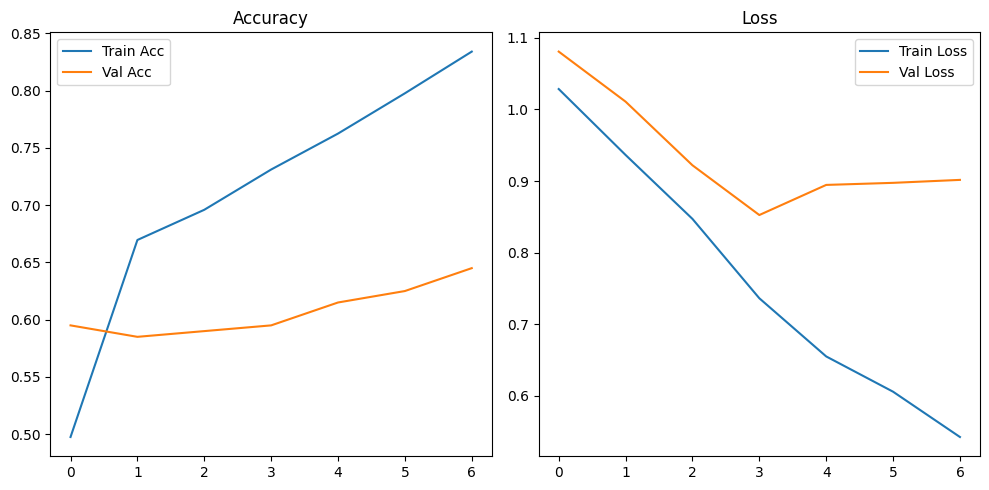

In [299]:
train_loss_gru_2000 = history_gru_2000.history['loss']
val_loss_gru_2000 = history_gru_2000.history['val_loss']
epochs_range_2000 = range(1, len(train_loss_gru_2000) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_gru_2000.history['accuracy'], label='Train Acc')
axs[0].plot(history_gru_2000.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_gru_2000.history['loss'], label='Train Loss')
axs[1].plot(history_gru_2000.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plot Summary for BiGRU Base Model

The results for the base BiGRU look promising. Training accuracy is steadily increasing and training loss is steadily decreasing. Likewise, we're seeing a very slow but steady increase in validation accuracy. The validation loss initially decreases sharply before plateauing. The behavior of the validation accuracy and loss leads us to believe that more epochs might improve the model, so we will test that hypothesis and set the epochs to 15.

## Fine-Tuning BiGRU

### Adding Epochs

In [277]:
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

In [278]:
tf.random.set_seed(SEED)

model_gru_2000b = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [281]:
model_gru_2000b.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_gru_2000b = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/gru_2000b_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_gru_2000b = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_gru_2000b = model_gru_2000b.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=15,
    batch_size=32,
    callbacks=[earlystop_gru_2000b, checkpoint_gru_2000b] 
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5254 - loss: 1.0354
Epoch 1: saving model to models/gru_2000b_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.5280 - loss: 1.0341 - val_accuracy: 0.5300 - val_loss: 1.0332
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6692 - loss: 0.8963
Epoch 2: saving model to models/gru_2000b_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.6687 - loss: 0.8958 - val_accuracy: 0.5450 - val_loss: 0.9314
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6983 - loss: 0.7948
Epoch 3: saving model to models/gru_2000b_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6981 - loss: 0.7944 - val_accuracy: 0.5500 - val_loss: 0.8712
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7138 - loss: 0.7232
Epoch 4: saving model to models/gru_2000b_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.7138 - loss: 0.7230 - 

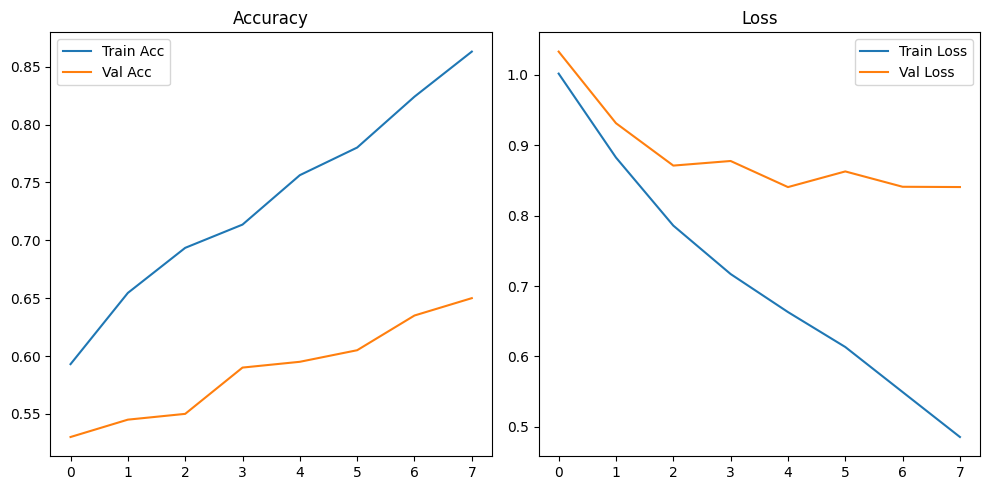

In [282]:
train_loss_gru_2000b = history_gru_2000b.history['loss']
val_loss_gru_2000b = history_gru_2000b.history['val_loss']
epochs_range_2000b = range(1, len(train_loss_gru_2000b) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_gru_2000b.history['accuracy'], label='Train Acc')
axs[0].plot(history_gru_2000b.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_gru_2000b.history['loss'], label='Train Loss')
axs[1].plot(history_gru_2000b.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plots After 15 Epochs

Increasing the epochs to 15 did not give drastically better results than the original rate of 10 epochs. We are continuing to see a plateau in the loss function. 

### Additional GRU layer

To address the plateauing of validation loss, we are going to introduce an additional GRU layer in the architecture. This added depth may help the model generalize better and improve validation performance.

In [305]:
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True  
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))


tf.random.set_seed(SEED)

model_gru_2000d = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [308]:
model_gru_2000d.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_gru_2000d = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/gru_2000d_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_gru_2000d = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_gru_2000d = model_gru_2000d.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_gru_2000d, checkpoint_gru_2000d] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5043 - loss: 1.0429
Epoch 1: saving model to models/gru_2000d_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.5069 - loss: 1.0417 - val_accuracy: 0.5500 - val_loss: 1.0286
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.6822 - loss: 0.8819
Epoch 2: saving model to models/gru_2000d_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - accuracy: 0.6813 - loss: 0.8811 - val_accuracy: 0.5900 - val_loss: 0.8622
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6491 - loss: 0.8129
Epoch 3: saving model to models/gru_2000d_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - accuracy: 0.6491 - loss: 0.8128 - val_accuracy: 0.5850 - val_loss: 0.8817
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6658 - loss: 0.7765
Epoch 4: saving model to models/gru_2000d_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.6666 - loss: 0.7759 -

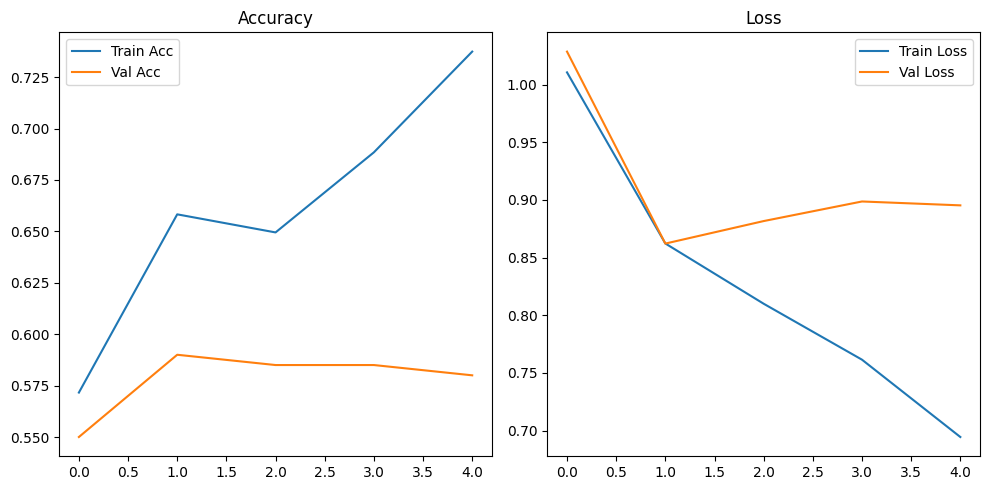

In [309]:
train_loss_gru_2000d = history_gru_2000d.history['loss']
val_loss_gru_2000d = history_gru_2000d.history['val_loss']
epochs_range_2000d = range(1, len(train_loss_gru_2000d) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_gru_2000d.history['accuracy'], label='Train Acc')
axs[0].plot(history_gru_2000d.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_gru_2000d.history['loss'], label='Train Loss')
axs[1].plot(history_gru_2000d.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plots of BiGRU with Stacked Layers

The results for the additional layer did not improve the validation results. We're continuing to see a plateau, so we're going to try a different tactic.

### Global Max Pooling 

Since adding an additional layer did not improve our validation results, we will remove it. In its place, we will introduce a Global Max Pooling layer to our architecture. This layer captures the most important features across the sequence and helps reduce overfitting through dimensionality reduction, which in turn limits the number of parameters in the model. By promoting better generalization, it may help close the gap between the training and validation performance.

In [313]:
MAX_LEN = 2000
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_train_pad.shape, X_val_pad.shape

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))


tf.random.set_seed(SEED)

model_gru_2000f = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_gru_2000f.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint_gru_2000f = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/gru_2000f_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,  
    verbose=1
)

earlystop_gru_2000f = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

history_gru_2000f = model_gru_2000f.fit(
    X_train_pad,
    y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    class_weight=class_weight_dict,  
    epochs=10,
    batch_size=32,
    callbacks=[earlystop_gru_2000f, checkpoint_gru_2000f] 
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3528 - loss: 1.1798
Epoch 1: saving model to models/gru_2000f_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.3556 - loss: 1.1767 - val_accuracy: 0.6300 - val_loss: 1.0091
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7311 - loss: 0.8585
Epoch 2: saving model to models/gru_2000f_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.7308 - loss: 0.8574 - val_accuracy: 0.6500 - val_loss: 0.8317
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7977 - loss: 0.6170
Epoch 3: saving model to models/gru_2000f_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.7974 - loss: 0.6162 - val_accuracy: 0.7050 - val_loss: 0.6163
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8397 - loss: 0.4552
Epoch 4: saving model to models/gru_2000f_epoch_04.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.8395 - loss: 0.4554 - 

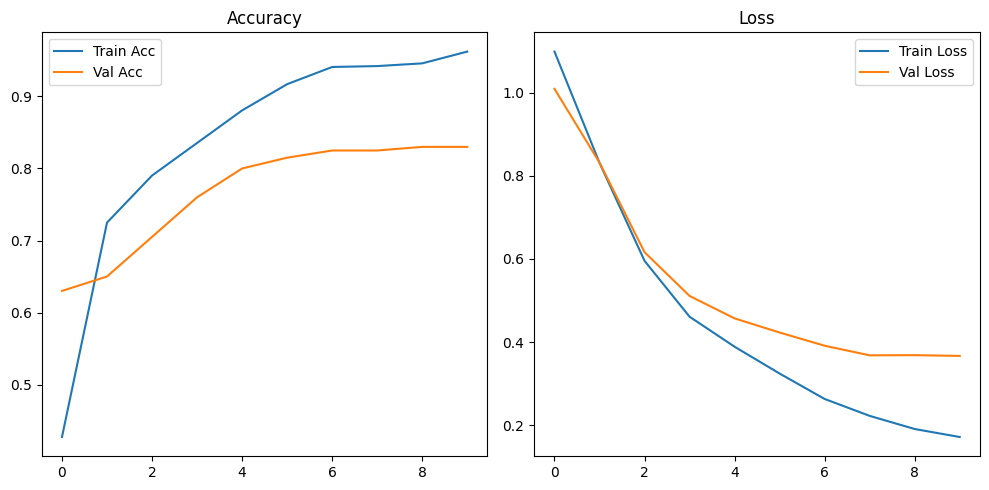

In [314]:
train_loss_gru_2000f = history_gru_2000f.history['loss']
val_loss_gru_2000f = history_gru_2000f.history['val_loss']
epochs_range_2000f = range(1, len(train_loss_gru_2000f) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axs[0].plot(history_gru_2000f.history['accuracy'], label='Train Acc')
axs[0].plot(history_gru_2000f.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history_gru_2000f.history['loss'], label='Train Loss')
axs[1].plot(history_gru_2000f.history['val_loss'], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy & Loss Plots for Global Max Pooling Addition

The Global Max Pooling layer has greatly improved the results on the validation accuracy seeing the highest accuracy yet. Likewise, the validation loss is the lowest its been in any of the models. We're also still seeing the increasing accuracy on the training data and decreasing training loss, so the changes to the BiGRU model have not negatively impacted learning on the training. 

# Evaluation 

We will be looking at the best BiLSTM and best BiGRU models and comparing the results.

Based on the accuracy and loss plots the best models were:
- BiLSTM architecture
  - A pre-defined BioWordVec embedding layer.
  - Max length set to 2,000 words.
  - Balanced class weights.
  - A Long Short-Term Memory (LSTM) layer with 64 units wrapped in a Bidirectional wrapper.
  - A dropout rate of 35% to the output of the LSTM layer to help prevent overfitting.
  - A fully connected (dense) layer with 64 units and ReLU activation.
  - A final output layer with 3 units and a softmax activation since there are more than 2 categories.

- BiGRU architecture
  - A pre-defined BioWordVec embedding layer.
  - Max length set to 2,000 words.
  - Balanced class weights.
  - A GRU layer with 64 units wrapped in a Bidirectional wrapper.
  - A dropout rate of 35% to the output of the GRU layer to help prevent overfitting.
  - A GlobalMaxPooling layer.
  - A fully connected (dense) layer with 64 units and ReLU activation.
  - A final output layer with 3 units and a softmax activation since there are more than 2 categories.
    

For evaluation metrics, we will be looking at the following:
- F1 score
  - The individual F1 scores for each model will be calculated.
  - The calclation for an F1 score is:
    
    F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
- Macro F1 score
  - The macro F1 score is a simple unweighted average of the individual F1 scores.
  - Using a macro F1 score prevents giving more weight to the majority class, in this case, the lung cancer category.
  - The calculation for a macro F1 score for 3 categories is:
    
     $\frac{F1_1+F1_2+F1_3}{3}$
- Confusion matrix
  - The confusion matrix will be produced to inspect misalingments in predictions.


### Classification Reports

To find the F1 scores and macro F1 scores for each of the models, we will be pulling in the saved epochs for each and the epoch with the best macro F1 score will be displayed in a classification report for comparison.

#### BiLSTM

In [316]:
model_paths = sorted(
    glob.glob("models/bilstm_2000b_epoch_*.keras"),
    key=lambda x: int(x.split("_epoch_")[1].split(".keras")[0])
)

model_scores = []

X_val_pad = tf.convert_to_tensor(X_val_pad, dtype=tf.float32)

@tf.function(reduce_retracing=True)

def run_inference(model, inputs):
    return model(inputs, training=False)



for model_path in model_paths:
    epoch_num = int(model_path.split("_epoch_")[1].split(".keras")[0])
    print(f"Evaluating model from Epoch {epoch_num}...")

    model = tf.keras.models.load_model(model_path)
    val_probs = model(X_val_pad, training=False)
    val_preds = tf.argmax(val_probs, axis=1).numpy()

    f1 = f1_score(y_val_enc, val_preds, average='macro')
    precision = precision_score(y_val_enc, val_preds, average='macro')
    recall = recall_score(y_val_enc, val_preds, average='macro')

    model_scores.append((epoch_num, f1, precision, recall))

# Sort results by F1 descending
model_scores.sort(key=lambda x: x[1], reverse=True)

# Print top 5 models
print("\nTop Epochs by Macro F1 Score:")
for epoch, f1, precision, recall in model_scores[:5]:
    print(f"Epoch {epoch:02d} — F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

#Full classification report for the best model
best_epoch_bilstm = model_scores[0][0]
best_model_path_bilstm = f"models/bilstm_2000b_epoch_{best_epoch_bilstm:02d}.keras"
best_model_bilstm = tf.keras.models.load_model(best_model_path_bilstm)

best_probs_bilstm = best_model_1000(X_val_pad, training=False)
best_preds_bilstm = tf.argmax(best_probs_bilstm, axis=1).numpy()

print("\nClassification Report for Best F1 Model for BiLSTM:\n")
print(classification_report(y_val_enc, best_preds_bilstm, target_names=le.classes_))

Evaluating model from Epoch 1...
Evaluating model from Epoch 2...
Evaluating model from Epoch 3...
Evaluating model from Epoch 4...
Evaluating model from Epoch 5...
Evaluating model from Epoch 6...
Evaluating model from Epoch 7...
Evaluating model from Epoch 8...
Evaluating model from Epoch 9...
Evaluating model from Epoch 10...

Top Epochs by Macro F1 Score:
Epoch 10 — F1: 0.6037 | Precision: 0.6063 | Recall: 0.6105
Epoch 04 — F1: 0.5910 | Precision: 0.6013 | Recall: 0.6064
Epoch 09 — F1: 0.5496 | Precision: 0.5492 | Recall: 0.5505
Epoch 05 — F1: 0.5375 | Precision: 0.5382 | Recall: 0.5396
Epoch 03 — F1: 0.5334 | Precision: 0.5542 | Recall: 0.5555

Classification Report for Best F1 Model for BiLSTM:

                precision    recall  f1-score   support

  Colon_Cancer       0.47      0.42      0.44        52
   Lung_Cancer       0.83      0.98      0.90        91
Thyroid_Cancer       0.41      0.33      0.37        57

      accuracy                           0.65       200
     ma

#### BiGRU

In [317]:
model_paths = sorted(
    glob.glob("models/gru_2000f_epoch_*.keras"),
    key=lambda x: int(x.split("_epoch_")[1].split(".keras")[0])
)

model_scores = []

X_val_pad = tf.convert_to_tensor(X_val_pad, dtype=tf.float32)

@tf.function(reduce_retracing=True)

def run_inference(model, inputs):
    return model(inputs, training=False)



for model_path in model_paths:
    epoch_num = int(model_path.split("_epoch_")[1].split(".keras")[0])
    print(f"Evaluating model from Epoch {epoch_num}...")

    model = tf.keras.models.load_model(model_path)
    val_probs = model(X_val_pad, training=False)
    val_preds = tf.argmax(val_probs, axis=1).numpy()

    f1 = f1_score(y_val_enc, val_preds, average='macro')
    precision = precision_score(y_val_enc, val_preds, average='macro')
    recall = recall_score(y_val_enc, val_preds, average='macro')

    model_scores.append((epoch_num, f1, precision, recall))

# Sort results by F1 descending
model_scores.sort(key=lambda x: x[1], reverse=True)

# Print top 5 models
print("\nTop Epochs by Macro F1 Score:")
for epoch, f1, precision, recall in model_scores[:5]:
    print(f"Epoch {epoch:02d} — F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

#Full classification report for the best model
best_epoch_gru = model_scores[0][0]
best_model_path_gru = f"models/gru_2000f_epoch_{best_epoch_gru:02d}.keras"
best_model_gru = tf.keras.models.load_model(best_model_path_gru)

best_probs_gru = best_model_gru(X_val_pad, training=False)
best_preds_gru = tf.argmax(best_probs_gru, axis=1).numpy()

print("\nClassification Report for Best F1 Model for GRU:\n")
print(classification_report(y_val_enc, best_preds_gru, target_names=le.classes_))

Evaluating model from Epoch 1...
Evaluating model from Epoch 2...
Evaluating model from Epoch 3...
Evaluating model from Epoch 4...
Evaluating model from Epoch 5...
Evaluating model from Epoch 6...
Evaluating model from Epoch 7...
Evaluating model from Epoch 8...
Evaluating model from Epoch 9...
Evaluating model from Epoch 10...

Top Epochs by Macro F1 Score:
Epoch 09 — F1: 0.7941 | Precision: 0.7943 | Recall: 0.7949
Epoch 10 — F1: 0.7890 | Precision: 0.8078 | Recall: 0.7967
Epoch 08 — F1: 0.7841 | Precision: 0.7861 | Recall: 0.7841
Epoch 07 — F1: 0.7833 | Precision: 0.7869 | Recall: 0.7835
Epoch 06 — F1: 0.7687 | Precision: 0.7767 | Recall: 0.7701

Classification Report for Best F1 Model for GRU:

                precision    recall  f1-score   support

  Colon_Cancer       0.66      0.71      0.69        52
   Lung_Cancer       1.00      0.99      0.99        91
Thyroid_Cancer       0.72      0.68      0.70        57

      accuracy                           0.83       200
     macro

### Summary of F1 Scores

For the BiLSTM model, the individual F1 scores show weak performance for the minority classes, with colon cancer at 0.44 and thyroid cancer at 0.37. These low scores contribute to a modest macro F1 score of 0.57. Conversely, the model performs well on the lung cancer class with an F1 score of 0.90. This result reflects its status as the majority class.

The GRU model, however, demonstrates much stronger overall performance, particularly for the minority classes. The F1 score for colon cancer improves to 0.69 and for thyroid cancer to 0.70, indicating the model is more effective at identifying these classes. The F1 score for lung cancer also improves slightly 0.99. Collectively, these contribute to an increased macro F1 score of 0.79, representing a significant improvement over the BiLSTM model.

## Confusion Matrices of Best Models 

Next we will look at the confusion matrices and discuss differences.

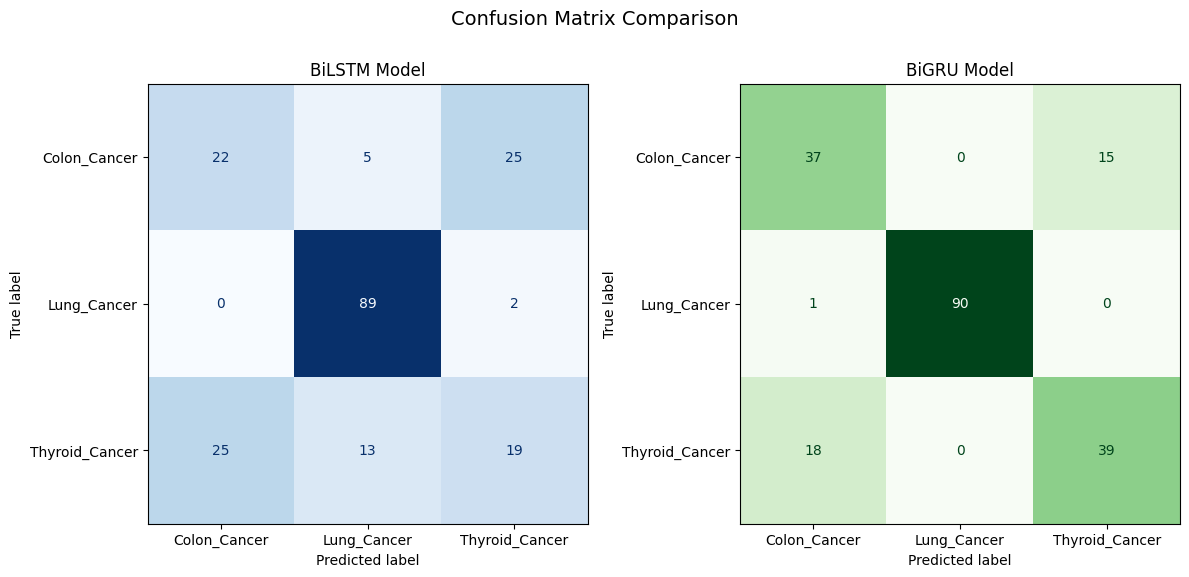

In [321]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# BiLSTM
cm_bilstm = confusion_matrix(y_val_enc, best_preds_bilstm)
labels = ["Colon_Cancer", "Lung_Cancer", "Thyroid_Cancer"]
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_bilstm, display_labels=labels)
disp_orig.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("BiLSTM Model")

# GRU
cm_gru = confusion_matrix(y_val_enc, best_preds_gru)
labels = ["Colon_Cancer", "Lung_Cancer", "Thyroid_Cancer"]
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=labels)
disp_gru.plot(ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("BiGRU Model")

plt.suptitle("Confusion Matrix Comparison", fontsize=14)
plt.tight_layout()
plt.show()

#### Summary of Confusion Matrices

The advantages of the BiGRU model are clearly reflected in the confusion matrices. Compared to the BiLSTM model, the BiGRU demonstrates significantly better accuracy in predicting the minority classes (colon cancer and thyroid cancer). In particular, it does not misclassify any minority class instances as lung cancer, the majority class, which was a frequent error in the BiLSTM model. 

While results are markedly improved over the tuned BiLSTM, it still struggles with misclassifying the minority classes as each other. This suggests that while BiGRU improves overall class balance and sensitivity, further tuning may be needed to better distinguish between the two minority categories.

## Evaluation Summary

The evaluation metrics confirm the tuned BiGRU performed better than any other model. Its F1 scores reflect strong performance across both majority and minority classes. In addition, the confusion matrix highlights its improved accuracy in identifying the minority classes. That being said, the BiGRU still struggled with misclassification between the minority classes and additional tuning may improve results.

# Conclusion & Discussion

A comparison of the best BiGRU and BiLSTM models showed that the BiGRU outperformed the BiLSTM in both validation metrics (validation accuracy and loss plots) and evaluation metrics (macro F1 and per class F1 scores). In addition, confusion matrix analysis showed the BiGRU was better at correctly identifying the minority classes (thyroid and colon cancers). The inclusion of a Global Max Pooling layer in the BiGRU architecture likely contributed to better generalization and reduced overfitting. 

Despite these improvements in performance, the BiGRU model still struggled with misclassifying the minority classes as each other. Given the dataset's relatively small size of approximately 1,000 records, the model's ability to learn complex patterns was likely limited. Further explorations in augmenting the underrepresented classes, fine-tuning the pretrained embeddings, and testing alternative architectures such as BioBERT may improve performance.

# References

Zhang Y, Chen Q, Yang Z, Lin H, Lu Z. BioWordVec, improving biomedical word embeddings with subword information and MeSH. Scientific Data. 2019.